In [1]:
#%load_ext autoreload
#%autoreload 2
%matplotlib inline
%cd '../'

/Users/joe/Documents/boulot/git/homhots/HOTS


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
import os
import time

from HOTS.ToolsMonitor import GenerateActivationMap, DisplayActivationMap
from HOTS.Event import Event, SimpleAlphabet, LoadNMNIST
from HOTS.STS import STS
from HOTS.Layer import ClusteringLayer
from HOTS.ToolsMonitor import (
    DisplayImage,
    DisplaySurface3D,
    DisplaySurface2D,
    DisplayConvergence,
)
from HOTS.Tools import SaveObject, LoadObject
from HOTS.Classifier import Classifier
from HOTS.Network import Network
from HOTS.KmeansLagorce import KmeansLagorce
from HOTS.KmeansMaro import KmeansMaro
from HOTS.conv2eve import conv2eve

tau = 1e-2 # -> tau=1ms, si on prend 10 ms on est à 1s pour la dernière couche et les vidéos font 0.3s en moyenne
R = 2
filthr = 2
nbkNN = 3
algo = 'lagorce'
krnlinit = 'rdn'
decay = 'exponential'
hom = True
nb_cluster = [4, 8, 16]
ImageSize = (34, 34)
DataPath = '../../../python/testsetnmnist.p'

NbClusteringData = 15
NbTrainingData = 40
NbTestingData = 40
event_tr, event_te, event_cl, label_tr, label_te = LoadNMNIST(
NbTrainingData, NbTestingData, NbClusteringData, Path=DataPath, OutOnePolarity=False, ListPolarities=None, verbose=0)

[]


In [ ]:
#tauz = np.array([1e-5,1e-4,2e-4,3e-4,4e-4,5e-4,6e-4,7e-4,8e-4,9e-4,1e-3,1.5e-3,2e-3,2.5e-3,3e-3,4e-3,5e-3,1e-2,2e-2])
tauz = [9e-4]
for i in range(len(tauz)):
    tau = tauz[i]
    #timestr = time.strftime("%Y%m%d")
    timestr = '20201023idv+'
    if hom==True:
        fname = 'Records/EXP_03_NMNIST/'+timestr+'_hots_'+str(tau*1000)+'ms_'+algo+'_homeo.pkl'
    else:
        fname = 'Records/EXP_03_NMNIST/'+timestr+'_hots_'+str(tau*1000)+'ms_'+algo+'.pkl'
    print(fname)

    L1 = ClusteringLayer(
        tau=tau,
        R=R,
        verbose=0,
        ThrFilter=filthr,
        LearningAlgo=algo,
        kernel=decay,
        homeo=hom,
        init=krnlinit
    )
    L2 = ClusteringLayer(
        tau=10 * tau,
        R=2 * R,
        verbose=0,
        ThrFilter=filthr,
        LearningAlgo=algo,
        kernel=decay,
        homeo=hom,
        init=krnlinit
    )
    L3 = ClusteringLayer(
        tau=10 * 10 * tau,
        R=2 * 2 * R,
        verbose=0,
        ThrFilter=filthr,
        LearningAlgo=algo,
        kernel=decay,
        homeo=hom,
        init=krnlinit
    )
    Net = Network([L1, L2, L3])
    if not os.path.isfile(fname):
        #### Training The Cluster on 5 images
        ClusterLayer, event_output = Net.TrainCluster(
            event=event_cl, NbClusterList=nb_cluster, to_record=True, NbCycle=1
        )
        print('end training')
        ## Generating histogram for training samples
        event0_o_tr = Net.RunNetwork(event_tr, NbClusterList=ClusterLayer)
        print('end groundtruth')
        ## Generating histogram for the test samples
        event0_o_te = Net.RunNetwork(event_te, NbClusterList=ClusterLayer)
        print('end test')
        Classif0 = Classifier(
            event0_o_tr, event0_o_te, TrainingLabel=label_tr, GroundTruth=label_te
        )
        print('init classif')
        prediction, accuracy, method = Classif0.HistogramDistance(knn=nbkNN, to_print=True)
        SaveObject([ClusterLayer, Classif0], fname)
    else:
        ClusterLayer, Classif0 = LoadObject(fname)
        prediction, accuracy, method = Classif0.HistogramDistance(knn=nbkNN, to_print=True)

Records/EXP_03_NMNIST/20201023idv+_hots_0.9ms_lagorce_homeo.pkl


[3]


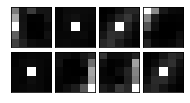

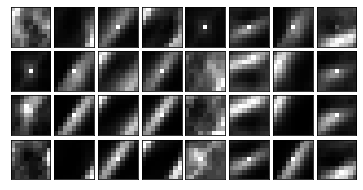

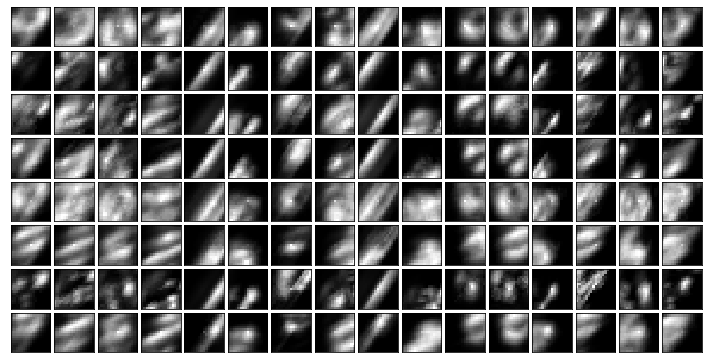

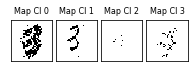

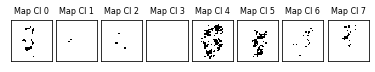

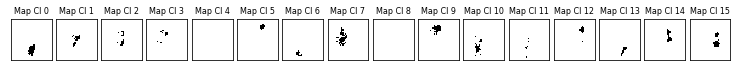

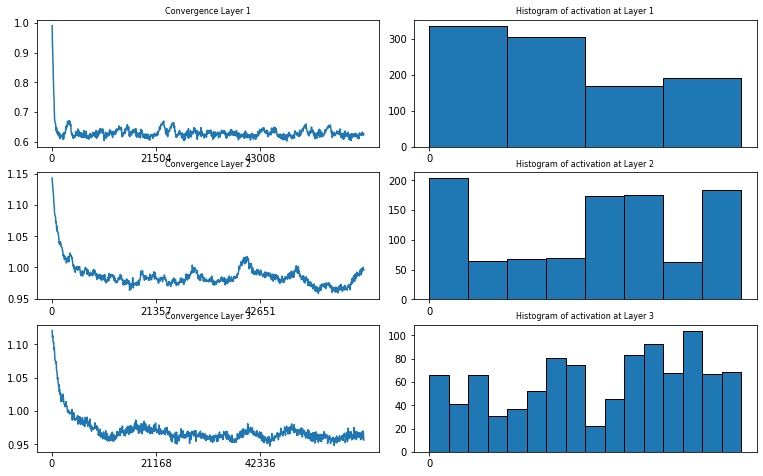

In [4]:
DisplaySurface2D(ClusterLayer[0].prototype, nb_polarities=2)
DisplaySurface2D(ClusterLayer[1].prototype, nb_polarities=4)
DisplaySurface2D(ClusterLayer[2].prototype, nb_polarities=8)

event_to_show, eventnul, eventnull, labelnul, labelnull = LoadNMNIST(
1, 0, 0, Path=DataPath, OutOnePolarity=False, ListPolarities=None, verbose=0)
Net.RunNetwork(event_to_show, NbClusterList=ClusterLayer)
mapL1 = GenerateActivationMap(Net.Layers[0].output, ClusterLayer[0])
DisplayActivationMap(mapL1, scale=2)
mapL2 = GenerateActivationMap(Net.Layers[1].output, ClusterLayer[1])
DisplayActivationMap(mapL2, scale=2)
mapL3 = GenerateActivationMap(Net.Layers[2].output, ClusterLayer[2])
DisplayActivationMap(mapL3, scale=2)

DisplayConvergence(ClusterLayer, to_display=["error", "histo"])

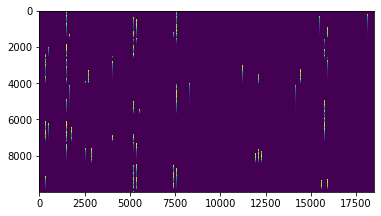

In [4]:
imlen = ImageSize[0]*ImageSize[1]
taucla = 1e-2
X = np.zeros([len(Classif0.event_train.time), imlen*nb_cluster[-1]])
y = np.zeros([len(Classif0.event_train.time)])
addr = Classif0.event_train.address[0]*ImageSize[0]+Classif0.event_train.address[1]+imlen*Classif0.event_train.polarity[0]
X[0][addr]=1
y[0] = Classif0.GroundTruth[0]
il = 0
for i in range(1,len(Classif0.event_train.time)):
    if i-1 not in Classif0.event_train.ChangeIdx:
        X[i] = X[i-1]*np.exp((Classif0.event_train.time[i-1]-Classif0.event_train.time[i])/taucla)
    else:
        il += 1
        #print(np.exp((Classif0.event_train.time[i-1]-Classif0.event_train.time[i])/taucla))
    addr = Classif0.event_train.address[i][0]*ImageSize[0]+Classif0.event_train.address[i][1]+imlen*Classif0.event_train.polarity[i]
    X[i][addr] = 1
    y[i] = Classif0.GroundTruth[il]
plt.imshow(X[:10000])

In [5]:
print(y)
#plt.imshow(X[10000:20000])

[0. 7. 7. ... 8. 8. 8.]


In [7]:
print(Classif0.GroundTruth
    )

[['7.0']
 ['0.0']
 ['2.0']
 ['0.0']
 ['6.0']
 ['1.0']
 ['5.0']
 ['1.0']
 ['8.0']
 ['8.0']
 ['5.0']
 ['5.0']
 ['2.0']
 ['4.0']
 ['9.0']
 ['5.0']
 ['2.0']
 ['1.0']
 ['9.0']
 ['5.0']
 ['3.0']
 ['2.0']
 ['3.0']
 ['9.0']
 ['6.0']
 ['1.0']
 ['3.0']
 ['2.0']
 ['0.0']
 ['3.0']
 ['2.0']
 ['2.0']
 ['2.0']
 ['2.0']
 ['5.0']
 ['5.0']
 ['4.0']
 ['9.0']
 ['8.0']
 ['8.0']]


In [7]:
from sklearn.decomposition import PCA
from HOTS.Tools import GenerateHistogram
histo_train, pola_train = GenerateHistogram(Classif0.event_train)
pca = PCA(n_components=2)
pca.fit(histo_train)

PCA(copy=True, iterated_power='auto', n_components=2, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

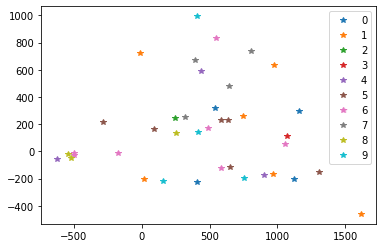

In [8]:
ax = []
a = np.dot(histo_train,pca.components_.T)
for i in range(10):
    ilab = np.where(Classif0.GroundTruth==[str(float(i))])[0]
    scatx = np.zeros([len(ilab)])
    scaty = np.zeros([len(ilab)])
    k=0
    for j in ilab:
        scatx[k] = a[j][0]
        scaty[k] = a[j][1]
        k+=1
    ax += plt.plot(scatx,scaty, '*', label=str(i))
labelz = [l.get_label() for l in ax]
plt.legend(ax, labelz)
plt.show()

In [27]:
Classif0.event_train.ChangeIdx

array([  3290,   8474,  13515,  17330,  23351,  29452,  34439,  40311,
        43348,  47400,  49081,  53942,  56169,  60812,  65022,  68778,
        71386,  74714,  80582,  84283,  87008,  89722,  93743,  97164,
       101298, 104024, 107188, 111391, 115861, 120398, 125186, 132016,
       136437, 139132, 142710, 147015, 151124, 153827, 157696, 159998])

In [34]:
from sklearn.decomposition import PCA
from HOTS.Tools import GenerateHistogram
nbevents = 500
output = np.zeros([Classif0.event_train.ChangeIdx.shape[0],nbevents])
output[0] = Classif0.event_train.polarity[:nbevents]
for i in range(Classif0.event_train.ChangeIdx.shape[0]):
    output[i] = Classif0.event_train.polarity[Classif0.event_train.ChangeIdx[i]:Classif0.event_train.ChangeIdx[i]+nbevents]
pca = PCA(n_components=2)
pca.fit(output)

PCA(copy=True, iterated_power='auto', n_components=2, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

In [7]:
ax = []
a = np.dot(output,pca.components_.T)
for i in range(10):
    ilab = np.where(Classif0.GroundTruth==[str(float(i))])[0]
    scatx = np.zeros([len(ilab)])
    scaty = np.zeros([len(ilab)])
    k=0
    for j in ilab:
        scatx[k] = a[j][0]
        scaty[k] = a[j][1]
        k+=1
    ax += plt.plot(scatx,scaty, '*', label=str(i))
labelz = [l.get_label() for l in ax]
plt.legend(ax, labelz)
plt.show()

NameError: name 'output' is not defined

In [6]:
a = [1e-5,1e-4,5e-4,1e-3,2.5e-3,4e-3,5e-3,1e-2,2e-2]
for idx in a:
    print(idx)

TypeError: cannot unpack non-iterable float object

In [13]:
*map(lambda x: 3 * x**2, Classif0.event_train.ChangeIdx),

ValueError: only 2 non-keyword arguments accepted

In [4]:
import numpy as np
a = np.ones([10])*100
for i in range(200):
    if i in a:
        print(i, np.where(a==i))

100 (array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),)


In [12]:
x = np.linspace(0,1,50)

/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: divide by zero encountered in true_divide
/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: divide by zero encountered in log
/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: divide by zero encountered in log
/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log
/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in log
/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:41: RuntimeWarning: divide by zero encountered in log


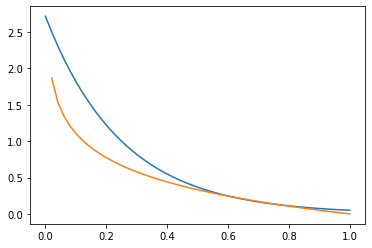

In [17]:
import numpy as np
import random
import matplotlib.pyplot as plt
N = 4
valmin = 0.7
valmax = 1.3
n = 1
p = 1
x = np.linspace(0,1,50)
f1 = np.exp((x-1/N)*-N)
N = 8
f2 = np.exp((x-1/N)*N)
N = 16
f3 = np.exp((x-1/N)*N)
N = 32
f4 = np.exp((x-1/N)*N)
j1 = np.log(np.exp(1)*(N-1)*x/(p-x/p))
p = 2
j2 = np.log(np.exp(1)*(N-1)*x/(p-x/p))
p = 3
j3 = np.log(np.exp(1)*(N-1)*x/(p-x/p))
b = np.log(valmax)*np.log(valmin)/((N-1)*np.log(valmin)+np.log(valmax))
d = b/np.log(valmin)
a = -b*N
k = np.exp((a*x+b)/(d-x))
valmin = 0.6
valmax = 2*1.4
b = np.log(valmax)*np.log(valmin)/((N-1)*np.log(valmin)+np.log(valmax))
d = b/np.log(valmin)
a = -b*N
k2 = np.exp((a*x+b)/(d-x))
valmin = 0.5
valmax = 2*1.5
b = np.log(valmax)*np.log(valmin)/((N-1)*np.log(valmin)+np.log(valmax))
d = b/np.log(valmin)
a = -b*N
k3 = np.exp((a*x+b)/(d-x))
l = np.log(x+0.2)
m = -np.log(1-(x+0.2))
N = 8
h = np.log(x)/np.log(1/N)
plt.plot(x,f1, x,h)

In [13]:
a = np.ones([20,2])*25
print(np.sum(a)*a)
print(np.sum(np.sqrt(a), axis=0))

[[25000. 25000.]
 [25000. 25000.]
 [25000. 25000.]
 [25000. 25000.]
 [25000. 25000.]
 [25000. 25000.]
 [25000. 25000.]
 [25000. 25000.]
 [25000. 25000.]
 [25000. 25000.]
 [25000. 25000.]
 [25000. 25000.]
 [25000. 25000.]
 [25000. 25000.]
 [25000. 25000.]
 [25000. 25000.]
 [25000. 25000.]
 [25000. 25000.]
 [25000. 25000.]
 [25000. 25000.]]
[100. 100.]
